# Imports

In [654]:
import pandas as pd
from bicm import BipartiteGraph
import numpy as np
from tqdm import tqdm
import seaborn as sns
import csv
import itertools 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import math
import seaborn as sns
from matplotlib.pyplot import figure
from scipy import stats
from scipy.stats import kendalltau
import pubchempy as pcp
import networkx as nx

# plt.rcParams['font.family'] = 'Times New Roman'

# Loading AI-Bind Data

In [196]:
sars_unseen_targets = pd.read_csv('/data/sars-busters-consolidated/GitData/sars_cov_2_predicitons_unseen_nodes.csv')
human_unseen_targets = pd.read_csv('/data/sars-busters-consolidated/GitData/human_preidcitons_unseen_nodes.csv')

In [197]:
all_pairs = pd.concat([sars_unseen_targets[['InChiKey','target_aa_code','gene','Averaged Predictions']],human_unseen_targets.rename(columns={'hgnc_symbol':'gene'})[['InChiKey','target_aa_code','gene','Averaged Predictions']]])

all_pairs['is_viral'] = [1]*len(sars_unseen_targets) + [0]*len(human_unseen_targets)

In [198]:
all_pairs_sorted = all_pairs.sort_values(by=['Averaged Predictions'], ascending=False)

In [199]:
all_pairs_sorted

,InChiKey,target_aa_code,gene,Averaged Predictions,is_viral
333533,OWWLUIWOFHMHOQ-XGHATYIMSA-N,QEMHNFEEELTCPICYSIFEDPRVLPCSHTFCRNCLENILQASGNF...,TRIM59,0.438937,0
333618,OWWLUIWOFHMHOQ-XGHATYIMSA-N,KLNVQKSQVYLYTNDRQMESQIMSKHPFIIATKRIKYLGIQLTRDM...,FAR2,0.433777,0
333304,OWWLUIWOFHMHOQ-XGHATYIMSA-N,QSKTLSLKKKKKKKATFCLYNCQDFGLVCVWVVVVVLSGDTEPRFG...,ZC3H18,0.432257,0
1362803,GVEAYVLWDAFXET-XGHATYIMSA-N,QEMHNFEEELTCPICYSIFEDPRVLPCSHTFCRNCLENILQASGNF...,TRIM59,0.429415,0
1362888,GVEAYVLWDAFXET-XGHATYIMSA-N,KLNVQKSQVYLYTNDRQMESQIMSKHPFIIATKRIKYLGIQLTRDM...,FAR2,0.424415,0
...,...,...,...,...,...
2483293,OLESAACUTLOWQZ-UHFFFAOYSA-L,VLMGRVPDRGGRPNEIEPPPPEMPPWQKRQDGPQQQTGGRGGGRGG...,FAM98A,0.000021,0
389520,LHAHECCJWGXHOW-UHFFFAOYSA-N,GERELLQAAKENLTAQVEHLQAAVVEARAQASAAGILEEDLRTARS...,CEP250,0.000021,0
996060,FUTVBRXUIKZACV-RGGAHWMASA-L,GERELLQAAKENLTAQVEHLQAAVVEARAQASAAGILEEDLRTARS...,CEP250,0.000014,0
368653,ZROHGHOFXNOHSO-BNTLRKBRSA-L,VLMGRVPDRGGRPNEIEPPPPEMPPWQKRQDGPQQQTGGRGGGRGG...,FAM98A,0.000012,0


In [200]:
all_pairs_sorted.head(100)['is_viral'].tolist().count(1)

0

In [201]:
all_pairs_sorted.tail(100)['is_viral'].tolist().count(1)

0

In [202]:
all_pairs_sorted.head(100).to_csv('/data/sars-busters-consolidated/GitData/top_100_predictions_VecNet_11_15_2021.csv')

In [203]:
all_pairs_sorted.tail(100).to_csv('/data/sars-busters-consolidated/GitData/bottom_100_predictions_VecNet_11_15_2021.csv')

In [633]:
top_100_drugs = all_pairs_sorted.groupby(['InChiKey']).mean().sort_values(by=['Averaged Predictions'], ascending=False).head(50)
top_100_drugs = pd.DataFrame(top_100_drugs)

# Check with paper: https://doi.org/10.1128/aac.00819-20

In [619]:
len(set(all_pairs['InChiKey']))

8111

In [620]:
top_24_inchikeys = ['MPMFCABZENCRHV-UHFFFAOYSA-N','PMATZTZNYRCHOR-CGLBZJNRSA-N','DOIQAHITMMDAJ-UHFFFAOYSA-N','XEEQGYMUWCZPDN-UHFFFAOYSA-N','OVCDSSHSILBFBN-UHFFFAOYSA-N','MYEJFUXQJGHEQK-ALRJYLEOSA-N','WDJUZGPOPHTGOT-XUDUSOBPSA-N','LTMHDMANZUZIPE-PUGKRICDSA-N','ACGUYXCXAPNIKK-UHFFFAOYSA-N','DOMWKUIIPQCAJU-LJHIYBGHSA-N','KQXDHUJYNAXLNZ-XQSDOZFQSA-N','LPMXVESGRSUGHW-HBYQJFLCSA-N','YVPXVXANRNDGTA-WDYNHAJCSA-N','LUKZNWIVRBCLON-GXOBDPJESA-N','JYWIYHUXVMAGLG-UHFFFAOYSA-N','JHVAMHSQVVQIOT-MFAJLEFUSA-N','GYQYAJJFPNQOOW-UHFFFAOYSA-N','DFOCUWZXJBAUSQ-URLMMPGGSA-N','WVTKBKWTSCPRNU-KYJUHHDHSA-N','UZWDCWONPYILKI-UHFFFAOYSA-N','PURKAOJPTOLRMP-UHFFFAOYSA-N','UCJGJABZCDBEDK-UHFFFAOYSA-N','RJMUSRYZPJIFPJ-UHFFFAOYSA-N','SVOQIEJWJCQGDQ-UHFFFAOYSA-N']

In [621]:
len(top_24_inchikeys)

24

In [631]:
common_drugs = set(top_100_drugs.index.values).intersection(set(top_24_inchikeys))
print(len(common_drugs))

2


In [632]:
common_drugs

{'JHVAMHSQVVQIOT-MFAJLEFUSA-N', 'PMATZTZNYRCHOR-CGLBZJNRSA-N'}

# Viral VS Human Genes

In [326]:
sars_unseen_targets = pd.read_csv('/data/sars-busters-consolidated/GitData/sars_cov_2_predicitons_unseen_nodes.csv')
human_unseen_targets = pd.read_csv('/data/sars-busters-consolidated/GitData/human_preidcitons_unseen_targets.csv')

In [327]:
sars_unseen_targets_averaged = sars_unseen_targets[['InChiKey','Averaged Predictions']]
sars_unseen_targets_averaged = sars_unseen_targets_averaged.groupby('InChiKey').mean().reset_index()
sars_unseen_targets_averaged_descending = sars_unseen_targets_averaged.sort_values(by=['Averaged Predictions'], ascending=False)

human_unseen_targets_averaged = human_unseen_targets[['InChiKey','Averaged Predictions']]
human_unseen_targets_averaged = human_unseen_targets_averaged.groupby('InChiKey').mean().reset_index()
human_unseen_targets_averaged_descending = human_unseen_targets_averaged.sort_values(by=['Averaged Predictions'], ascending=False)

In [328]:
len(set(sars_unseen_targets_averaged_descending.head(100)['InChiKey'].tolist()).intersection(set(human_unseen_targets_averaged_descending.head(100)['InChiKey'].tolist())))

15

In [329]:
sars_unseen_targets_averaged_descending.head(10)['InChiKey'].tolist()

['IUCCYQIEZNQWRS-DWWHXVEHSA-N',
 'NSPHQWLKCGGCQR-DLJDZFDSSA-N',
 'MDCUNMLZLNGCQA-HWOAGHQOSA-N',
 'CLKOFPXJLQSYAH-ABRJDSQDSA-N',
 'TURJYGRXEJIBGT-OCOMGVANSA-N',
 'BPKIMPVREBSLAJ-QTBYCLKRSA-N',
 'JYIKNQVWKBUSNH-OGZDCFRISA-N',
 'UTQHLYJFMFKSGI-UBINZTMLSA-N',
 'WQVJHHACXVLGBL-BPJDFBQWSA-N',
 'PZBPHYLKIMOZPR-ZWIFOJARSA-K']

In [330]:
human_unseen_targets_averaged_descending.head(10)['InChiKey'].tolist()

['DFYPFJSPLUVPFJ-QJEDTDQSSA-N',
 'RCFZILUHCNXXFY-DEDWCYLFSA-N',
 'RMTMMKNSPRRFHW-UHFFFAOYSA-N',
 'NMYKBZSMOUFOJV-UHFFFAOYSA-N',
 'WEGJDERSZWOWIB-UHFFFAOYSA-N',
 'GBLRQXKSCRCLBZ-UHFFFAOYSA-N',
 'AMYWSBYLSVHSHG-UHFFFAOYSA-N',
 'RJURFGZVJUQBHK-IIXSONLDSA-N',
 'GQLCLPLEEOUJQC-ZTQDTCGGSA-N',
 'ZQLDXCSTJFLRPY-RWBXLJKRSA-N']

# Auto Docking 

In [348]:
auto_docking_results = pd.read_csv('/data/sars-busters-consolidated/GitData/docking.csv')

In [349]:
auto_docking_results_refreshed = pd.read_csv('/data/sars-busters-consolidated/GitData/new_top_100_auto_docking.csv')

In [350]:
auto_docking_results = auto_docking_results[['InChiKey','target_aa_code','Averaged Predictions','is_ligand_available','is_protein_available','gene','Binding Affinity in kcal/mole']]
auto_docking_results_refreshed = auto_docking_results_refreshed[['InChiKey','target_aa_code','Averaged Predictions','is_ligand_available','is_protein_available','gene','Binding Affinity in kcal/mole']]

auto_docking_results = pd.concat([auto_docking_results_refreshed,auto_docking_results])

In [351]:
auto_docking_results

,InChiKey,target_aa_code,Averaged Predictions,is_ligand_available,is_protein_available,gene,Binding Affinity in kcal/mole
0,OWWLUIWOFHMHOQ_XGHATYIMSA_N,QEMHNFEEELTCPICYSIFEDPRVLPCSHTFCRNCLENILQASGNF...,0.438937,NaN,NaN,TRIM59,-7.6
1,OWWLUIWOFHMHOQ_XGHATYIMSA_N,KLNVQKSQVYLYTNDRQMESQIMSKHPFIIATKRIKYLGIQLTRDM...,0.433777,NaN,NaN,FAR2,-9.1
2,OWWLUIWOFHMHOQ_XGHATYIMSA_N,QSKTLSLKKKKKKKATFCLYNCQDFGLVCVWVVVVVLSGDTEPRFG...,0.432257,NaN,NaN,ZC3H18,-7.1
3,GVEAYVLWDAFXET_XGHATYIMSA_N,QEMHNFEEELTCPICYSIFEDPRVLPCSHTFCRNCLENILQASGNF...,0.429415,NaN,NaN,TRIM59,-7.9
4,GVEAYVLWDAFXET_XGHATYIMSA_N,KLNVQKSQVYLYTNDRQMESQIMSKHPFIIATKRIKYLGIQLTRDM...,0.424415,NaN,NaN,FAR2,-9.5
...,...,...,...,...,...,...,...
195,HBZDUNQUBNOQIC-UHFFFAOYSA-N,PRRARRVCATAENTECWSHGACRAASRRALRTFPASSSVAPRPGAS...,0.000084,no such ligand,1GXR,TLE1,NaN
196,CTVHSHALRXJQNK-ZHZUXMKXSA-M,VAPMVDPVTLWGTRVCLGSGQCQCAISENPGQRVAPVVGCGHPGVA...,0.000090,NaN,6V6B,TUBGCP3,-10.3
197,XCPVAMYUZCTTHM-UHFFFAOYSA-N,VAPMVDPVTLWGTRVCLGSGQCQCAISENPGQRVAPVVGCGHPGVA...,0.000077,NaN,6V6B,TUBGCP3,-6.3
198,XCPVAMYUZCTT-UHFFFAOYSA-N,GYRLTASQGRRIFLSTEQNGVSYVYFFLHKHSNNLISLSFPHISPF...,0.000045,NaN,protein not available,UBAP2,NaN


In [443]:
top_predictions = pd.read_csv('/data/sars-busters-consolidated/GitData/top_100_predictions_VecNet_11_15_2021.csv')
bottom_predictions = pd.read_csv('/data/sars-busters-consolidated/GitData/bottom_100_predictions_VecNet_11_15_2021.csv')

In [444]:
len(set(pd.concat([top_predictions,bottom_predictions])['InChiKey'].tolist()))

59

In [445]:
len(set(pd.concat([top_predictions,bottom_predictions])['target_aa_code'].tolist()))

54

In [446]:
docking_dict = dict()

for index, row in tqdm(auto_docking_results.iterrows()):
    docking_dict[(row['InChiKey'].replace('_','-'),row['target_aa_code'])] = dict()
    docking_dict[(row['InChiKey'].replace('_','-'),row['target_aa_code'])]['binding_affinity'] = row['Binding Affinity in kcal/mole']
    docking_dict[(row['InChiKey'].replace('_','-'),row['target_aa_code'])]['is_ligand_available'] = row['is_ligand_available']
    docking_dict[(row['InChiKey'].replace('_','-'),row['target_aa_code'])]['is_protein_available'] = row['is_protein_available']

300it [00:00, 3769.33it/s]


In [447]:
top_binding_scores = []
top_is_ligand_available_list = []
top_is_protein_available_list = []

for index, row in tqdm(top_predictions.iterrows()):
    try:
        top_binding_scores.append(docking_dict[(row['InChiKey'],row['target_aa_code'])]['binding_affinity'])
        top_is_ligand_available_list.append(docking_dict[(row['InChiKey'],row['target_aa_code'])]['is_ligand_available'])
        top_is_protein_available_list.append(docking_dict[(row['InChiKey'],row['target_aa_code'])]['is_protein_available'])
    except:
        top_binding_scores.append('none')
        top_is_ligand_available_list.append('none')
        top_is_protein_available_list.append('none')
    
bottom_binding_scores = []
bottom_is_ligand_available_list = []
bottom_is_protein_available_list = []

for index, row in tqdm(bottom_predictions.iterrows()):
    try:
        bottom_binding_scores.append(docking_dict[(row['InChiKey'],row['target_aa_code'])]['binding_affinity'])
        bottom_is_ligand_available_list.append(docking_dict[(row['InChiKey'],row['target_aa_code'])]['is_ligand_available'])
        bottom_is_protein_available_list.append(docking_dict[(row['InChiKey'],row['target_aa_code'])]['is_protein_available'])
    except:
        bottom_binding_scores.append('none')
        bottom_is_ligand_available_list.append('none')
        bottom_is_protein_available_list.append('none')
    

100it [00:00, 5205.66it/s]
100it [00:00, 5374.35it/s]


In [448]:
top_predictions['binding_affinity'] = top_binding_scores
top_predictions['is_ligand_available'] = top_is_ligand_available_list
top_predictions['is_protein_available'] = top_is_protein_available_list

bottom_predictions['binding_affinity'] = bottom_binding_scores
bottom_predictions['is_ligand_available'] = bottom_is_ligand_available_list
bottom_predictions['is_protein_available'] = bottom_is_protein_available_list

In [449]:
total_df = pd.concat([top_predictions,bottom_predictions])

In [450]:
len(set(total_df[total_df['is_ligand_available'] == 'no such ligand']['InChiKey']))

8

In [451]:
len(set(total_df[total_df['is_protein_available'] == 'protein not available']['target_aa_code']))

23

In [453]:
top_predictions_auto_docked = top_predictions[top_predictions['is_ligand_available'] != 'no such ligand']
top_predictions_auto_docked = top_predictions_auto_docked[top_predictions_auto_docked['is_protein_available'] != 'protein not available']

bottom_predictions_auto_docked = bottom_predictions[bottom_predictions['is_ligand_available'] != 'no such ligand']
bottom_predictions_auto_docked = bottom_predictions_auto_docked[bottom_predictions_auto_docked['is_protein_available'] != 'protein not available']

In [454]:
len(top_predictions_auto_docked)

84

In [455]:
len(bottom_predictions_auto_docked)

51

## Comparison of Rank Lists

In [520]:
total_df_auto_docked = pd.concat([top_predictions_auto_docked,bottom_predictions_auto_docked])
total_df_auto_docked = total_df_auto_docked[~total_df_auto_docked['binding_affinity'].isna()]
total_df_auto_docked = total_df_auto_docked[total_df_auto_docked['binding_affinity'] !='none']
total_df_top_20 = total_df_auto_docked.sort_values(by=['Averaged Predictions'], ascending=False).head(20)

In [522]:
stats.spearmanr(total_df_top_20['Averaged Predictions'].tolist(),total_df_top_20['binding_affinity'].tolist())

SpearmanrResult(correlation=-0.17306250196392406, pvalue=0.46559928988387644)

In [463]:
#total_df_top_20_ba = total_df.sort_values(by=['binding_affinity'], ascending=True).head(20)

In [464]:
#stats.spearmanr(total_df_top_20_ba['Averaged Predictions'].tolist(),total_df_top_20_ba['binding_affinity'].tolist())

In [523]:
stats.spearmanr(total_df_auto_docked['Averaged Predictions'].tolist(),total_df_auto_docked['binding_affinity'].tolist())

SpearmanrResult(correlation=-0.5105374885274542, pvalue=3.5011950967358208e-09)

In [526]:
bootstrap_rank_correlation = []

for i in range(5):
    samples_df = total_df_auto_docked.sample(20)
    bootstrap_rank_correlation.append(stats.spearmanr(samples_df['Averaged Predictions'].tolist(),samples_df['binding_affinity'].tolist()))

print('Mean and STD of rank correlation: ', np.mean(bootstrap_rank_correlation), np.std(bootstrap_rank_correlation))

Mean and STD of rank correlation:  -0.2736528582879162 0.3129918748801916


In [527]:
bootstrap_rank_correlation = []

for i in range(5):
    samples_df = total_df_auto_docked.sample(20)
    bootstrap_rank_correlation.append(kendalltau(samples_df['Averaged Predictions'].tolist(),samples_df['binding_affinity'].tolist()))

print('Mean and STD of rank correlation: ', np.mean(bootstrap_rank_correlation), np.std(bootstrap_rank_correlation))

Mean and STD of rank correlation:  -0.15028729988185277 0.21293319339702013


## F1-Score

In [539]:
top_predictions_auto_docked_f1 = top_predictions_auto_docked[~top_predictions_auto_docked['binding_affinity'].isna()]
top_predictions_auto_docked_f1 = top_predictions_auto_docked_f1[top_predictions_auto_docked_f1['binding_affinity'] !='none']

In [540]:
bottom_predictions_auto_docked_f1 = bottom_predictions_auto_docked[~bottom_predictions_auto_docked['binding_affinity'].isna()]
bottom_predictions_auto_docked_f1 = bottom_predictions_auto_docked_f1[bottom_predictions_auto_docked_f1['binding_affinity'] !='none']

In [603]:
TP = len(top_predictions_auto_docked_f1[top_predictions_auto_docked_f1['binding_affinity'] < -1.75])
print('True positives: ', TP)

True positives:  74


In [604]:
FP = len(top_predictions_auto_docked_f1[top_predictions_auto_docked_f1['binding_affinity'] >= -1.75]) + len(top_predictions_auto_docked[top_predictions_auto_docked['binding_affinity'].isna()])
print('False positives: ', FP)

False positives:  10


In [605]:
FN = len(bottom_predictions_auto_docked_f1[bottom_predictions_auto_docked_f1['binding_affinity'] < -1.75])
print('False negatives: ', FN)

False negatives:  23


In [606]:
TN = len(bottom_predictions_auto_docked_f1[bottom_predictions_auto_docked_f1['binding_affinity'] >= -1.75]) + len(bottom_predictions_auto_docked[bottom_predictions_auto_docked['binding_affinity'].isna()])
print('True negatives: ', TN)

True negatives:  21


In [607]:
N = TP + FP + FN + TN
S = (TP + FN) / N
P = (TP + FP) / N

matthew_coeff = ((TP/N) - (S*P)) / np.sqrt(P * S * (1-P) * (1-S))
print('Matthew correlation coefficient: ', matthew_coeff)

Matthew correlation coefficient:  0.3971506610666133


In [608]:
matthew_coeff = (TP*TN-FP*FN)/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
print('Matthew correlation coefficient: ', matthew_coeff)

Matthew correlation coefficient:  0.3971506610666133


In [609]:
Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
f1_score = 2 * (Precision * Recall) / (Precision + Recall)
print('F1-Score: ', f1_score)

F1-Score:  0.8176795580110496


In [549]:
# Bootstrapping for F1-Score

total_df_for_bootstrapping = pd.concat([top_predictions_auto_docked_f1,bottom_predictions_auto_docked_f1])
total_df_for_bootstrapping['AI_bind_labels'] = [1] * len(top_predictions_auto_docked_f1) + [0] * len(bottom_predictions_auto_docked_f1)
total_df_for_bootstrapping['auto_docking_labels'] = [1 if x < -1.75 else 0 for x in total_df_for_bootstrapping['binding_affinity'].tolist()]

In [550]:
f1_score_list = []
mcc_list = []

for i in range(5):
    sub_df = total_df_for_bootstrapping.sample(n=20)
    TP = len(sub_df[(sub_df['AI_bind_labels'] == 1) & (sub_df['auto_docking_labels'] == 1)])
    FP = len(sub_df[(sub_df['AI_bind_labels'] == 1) & (sub_df['auto_docking_labels'] == 0)])
    FN = len(sub_df[(sub_df['AI_bind_labels'] == 0) & (sub_df['auto_docking_labels'] == 1)])
    TN = len(sub_df[(sub_df['AI_bind_labels'] == 0) & (sub_df['auto_docking_labels'] == 0)])
    Precision = TP / (TP + FP)
    Recall = TP / (TP + FN)
    f1_score = 2 * (Precision * Recall) / (Precision + Recall)
    mcc = (TP*TN-FP*FN)/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
    f1_score_list.append(f1_score)
    mcc_list.append(mcc)

In [551]:
print('Mean of F1-Score: ', np.mean(f1_score_list))
print('STD of F1-Score: ', np.std(f1_score_list))

Mean of F1-Score:  0.9039467485919099
STD of F1-Score:  0.0188211117573441


In [552]:
print('Mean of MCC: ', np.mean(mcc_list))
print('STD of MCC: ', np.std(mcc_list))

Mean of MCC:  0.6590273354258277
STD of MCC:  0.1075627580739283


## Creating Table for Paper

In [644]:
top_predictions_ordered = top_predictions_auto_docked_f1.sort_values('Averaged Predictions', ascending=False)

prediction_percentile = []

for index, row in tqdm(top_predictions_ordered.iterrows()):
    prediction_percentile.append(stats.percentileofscore(all_pairs['Averaged Predictions'].tolist(), row['Averaged Predictions'], 'rank'))

top_predictions_ordered['Prediction_percentile'] = prediction_percentile


74it [00:30,  2.44it/s]


In [645]:
unique_top_ligands = list(set(top_predictions_ordered['InChiKey'].tolist()))

In [ ]:
ligand_name_dict = dict()

for lig in tqdm(unique_top_ligands):
    try:
        cc = pcp.get_compounds(lig, namespace ='inchikey')
        ligand_name_dict[lig] = cc[0].synonyms[0]
    except:
        print('Not foun: ', lig)

In [558]:
ligand_name_dict['HMEYVGGHISAPJR-IAHYZSEUSA-N'] = 'Rolitetracycline'
ligand_name_dict['DYKFCLLONBREIL-KVUCHLLUSA-N'] = 'Minocycline'

In [646]:
ligand_names = []

for index, row in tqdm(top_predictions_ordered.iterrows()):
    ligand_names.append(ligand_name_dict[row['InChiKey']].title())

top_predictions_ordered['ligand_name'] = ligand_names


74it [00:00, 7860.27it/s]


In [647]:
set(top_predictions_ordered['gene'].tolist())

{'DNMT1', 'FAR2', 'TRIM59', 'USP54', 'ZC3H18'}

In [648]:
protein_name_dict = dict()

protein_name_dict['DNMT1'] = 'DNMT1' # 'DNA (cytosine-5)-methyltransferase 1 (DNMT1)'
protein_name_dict['FAR2'] = 'FAR2' # 'Fatty acyl-CoA reductase 2 (FAR2)'
protein_name_dict['TRIM59'] = 'TRIM59' # 'Tripartite motif-containing protein 59 (TRIM59)'
protein_name_dict['USP54'] = 'USP54' # 'Ubiquitin carboxyl-terminal hydrolase 54 (USP54)'
protein_name_dict['ZC3H18'] = 'ZC3H18' # 'Zinc finger CCCH domain-containing protein 18 (ZC3H18)'

In [649]:
protein_names = []

for index, row in tqdm(top_predictions_ordered.iterrows()):
    protein_names.append(protein_name_dict[row['gene']])

top_predictions_ordered['protein_name'] = protein_names


74it [00:00, 8301.55it/s]


In [650]:
top_predictions_ordered

,Unnamed: 0,InChiKey,target_aa_code,gene,Averaged Predictions,is_viral,binding_affinity,is_ligand_available,is_protein_available,Prediction_percentile,ligand_name,protein_name
0,333533,OWWLUIWOFHMHOQ-XGHATYIMSA-N,QEMHNFEEELTCPICYSIFEDPRVLPCSHTFCRNCLENILQASGNF...,TRIM59,0.438937,0,-7.6,NaN,NaN,100.000000,Pipecuronium,TRIM59
1,333618,OWWLUIWOFHMHOQ-XGHATYIMSA-N,KLNVQKSQVYLYTNDRQMESQIMSKHPFIIATKRIKYLGIQLTRDM...,FAR2,0.433777,0,-9.1,NaN,NaN,99.999964,Pipecuronium,FAR2
2,333304,OWWLUIWOFHMHOQ-XGHATYIMSA-N,QSKTLSLKKKKKKKATFCLYNCQDFGLVCVWVVVVVLSGDTEPRFG...,ZC3H18,0.432257,0,-7.1,NaN,NaN,99.999929,Pipecuronium,ZC3H18
3,1362803,GVEAYVLWDAFXET-XGHATYIMSA-N,QEMHNFEEELTCPICYSIFEDPRVLPCSHTFCRNCLENILQASGNF...,TRIM59,0.429415,0,-7.9,NaN,NaN,99.999893,Pancuronium,TRIM59
4,1362888,GVEAYVLWDAFXET-XGHATYIMSA-N,KLNVQKSQVYLYTNDRQMESQIMSKHPFIIATKRIKYLGIQLTRDM...,FAR2,0.424415,0,-9.5,NaN,NaN,99.999857,Pancuronium,FAR2
...,...,...,...,...,...,...,...,...,...,...,...,...
95,1220573,SEALOBQTUQIVGU-QNIJNHAOSA-N,QEMHNFEEELTCPICYSIFEDPRVLPCSHTFCRNCLENILQASGNF...,TRIM59,0.387469,0,-8.0,NaN,NaN,99.996615,Dihydroergocornine,TRIM59
96,2610863,PKVRCIRHQMSYJX-AIFWHQITSA-N,QEMHNFEEELTCPICYSIFEDPRVLPCSHTFCRNCLENILQASGNF...,TRIM59,0.387410,0,-7.4,NaN,NaN,99.996579,Trabectedin,TRIM59
97,2151503,LKAJKIOFIWVMDJ-IYRCEVNGSA-N,QEMHNFEEELTCPICYSIFEDPRVLPCSHTFCRNCLENILQASGNF...,TRIM59,0.387335,0,-7.3,NaN,NaN,99.996543,Stanozolol,TRIM59
98,2031888,HTIKWNNIPGXLGM-YLINKJIISA-N,LALSICFSEQPIPLQVLLSQEAQLESGMDTEFGASSFFHSPASCHE...,USP54,0.387249,0,-8.1,NaN,NaN,99.996508,Rapacuronium,USP54


In [651]:
top_predictions_ordered_table_for_paper = top_predictions_ordered[['protein_name','ligand_name','Prediction_percentile','binding_affinity']]

In [652]:
top_predictions_ordered_table_for_paper

,protein_name,ligand_name,Prediction_percentile,binding_affinity
0,TRIM59,Pipecuronium,100.000000,-7.6
1,FAR2,Pipecuronium,99.999964,-9.1
2,ZC3H18,Pipecuronium,99.999929,-7.1
3,TRIM59,Pancuronium,99.999893,-7.9
4,FAR2,Pancuronium,99.999857,-9.5
...,...,...,...,...
95,TRIM59,Dihydroergocornine,99.996615,-8.0
96,TRIM59,Trabectedin,99.996579,-7.4
97,TRIM59,Stanozolol,99.996543,-7.3
98,USP54,Rapacuronium,99.996508,-8.1


In [653]:
top_predictions_ordered_table_for_paper.to_csv('/data/sars-busters-consolidated/GitData/top_predictions_ordered_table_for_paper_11_17_2021.csv')

## Lung-specific Proteins

In [610]:
set(top_predictions_auto_docked_f1['gene'].tolist())

{'DNMT1', 'FAR2', 'TRIM59', 'USP54', 'ZC3H18'}

In [615]:
lungs_protein = pd.read_csv('/data/sars-busters-consolidated/GitData/Lungs.csv')

In [617]:
set(top_predictions_auto_docked_f1['gene'].tolist()).intersection(set(lungs_protein['AAR2']))

{'DNMT1', 'FAR2', 'USP54', 'ZC3H18'}

In [618]:
#for protein in set(top_predictions_auto_docked_f1['gene'].tolist()):
#    top_predictions_protein= top_predictions_auto_docked_f1[top_predictions_auto_docked_f1['gene']==protein]
#    print('Protein: ', protein)
#    print('Rank correlation: ', stats.spearmanr(top_predictions_protein['Averaged Predictions'].tolist(),top_predictions_protein['binding_affinity'].tolist()))

## Other Statistics and Distribution Plots

In [579]:
mean_pred = np.mean(all_pairs['Averaged Predictions'].tolist())
std_pred = np.std(all_pairs['Averaged Predictions'].tolist())
print('Mean prediction: ', mean_pred)
print('STD prediction: ', std_pred)

Mean prediction:  0.08839766471272205
STD prediction:  0.05429933763833862


In [582]:
len(top_predictions_auto_docked_f1)

74

In [583]:
len(bottom_predictions_auto_docked_f1)

44

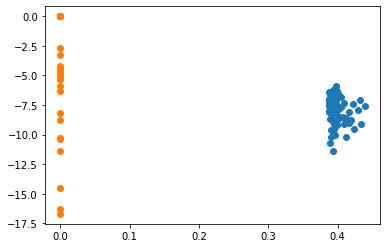

In [584]:
plt.scatter(top_predictions_auto_docked_f1['Averaged Predictions'].tolist(),top_predictions_auto_docked_f1['binding_affinity'].tolist())
plt.scatter(bottom_predictions_auto_docked_f1['Averaged Predictions'].tolist(),bottom_predictions_auto_docked_f1['binding_affinity'].tolist())

In [585]:
len(top_predictions_auto_docked_f1['binding_affinity'].tolist())

74

In [586]:
len(bottom_predictions_auto_docked_f1['binding_affinity'].tolist())

44

In [588]:
np.median(top_predictions_auto_docked_f1['binding_affinity'].tolist())

-7.65

In [587]:
np.median(bottom_predictions_auto_docked_f1['binding_affinity'].tolist())

-3.0

In [589]:
len(set(pd.concat([top_predictions_auto_docked_f1,bottom_predictions_auto_docked_f1])['target_aa_code'].tolist()))

26

In [590]:
len(set(pd.concat([top_predictions_auto_docked_f1,bottom_predictions_auto_docked_f1])['InChiKey'].tolist()))

49

In [591]:
len(set(pd.concat([top_predictions_auto_docked_f1,bottom_predictions_auto_docked_f1])['InChiKey'].tolist()))/len(set(auto_docking_results['InChiKey'].tolist()))

0.45794392523364486

In [592]:
top_predictions_auto_docked_f1[top_predictions_auto_docked_f1['binding_affinity']>-1]

,Unnamed: 0,InChiKey,target_aa_code,gene,Averaged Predictions,is_viral,binding_affinity,is_ligand_available,is_protein_available


In [16]:
top_predictions[top_predictions['binding_affinity']<-1]

,InChiKey,target_aa_code,gene,Averaged Predictions,is_viral,binding_affinity
33355,OWWLUIWOFHMHOQ-XGHATYIMSA-N,MDQREILQKFLDEAQSKKITKEEFANEFLKLKRQSTKYKADKTYPT...,PTPN22,0.555347,1,-8.5
136282,GVEAYVLWDAFXET-XGHATYIMSA-N,MDQREILQKFLDEAQSKKITKEEFANEFLKLKRQSTKYKADKTYPT...,PTPN22,0.546242,1,-8.6
33345,OWWLUIWOFHMHOQ-XGHATYIMSA-N,MQKIMHISVLLSPVLWGLIFGVSSNSIQIGGLFPRGADQEYSAFRV...,GRIA2,0.542733,1,-8.4
7615,DIGFQJFCDPKEPF-OIUSMDOTSA-L,MDQREILQKFLDEAQSKKITKEEFANEFLKLKRQSTKYKADKTYPT...,PTPN22,0.537954,1,-8.6
83383,JFXBEKISTKFVAB-AJQTZOPKSA-N,MDQREILQKFLDEAQSKKITKEEFANEFLKLKRQSTKYKADKTYPT...,PTPN22,0.536767,1,-8.6
...,...,...,...,...,...,...
245644,IVFYLRMMHVYGJH-PVPPCFLZSA-N,MDQREILQKFLDEAQSKKITKEEFANEFLKLKRQSTKYKADKTYPT...,PTPN22,0.499446,1,-8.2
127933,GJMNAFGEUJBOCE-MEQIQULJSA-N,MDQREILQKFLDEAQSKKITKEEFANEFLKLKRQSTKYKADKTYPT...,PTPN22,0.499281,1,-7.8
83365,JFXBEKISTKFVAB-AJQTZOPKSA-N,MNFNTILEEILIKRSQQKKKTSPLNYKERLFVLTKSMLTYYEGRAE...,TEC,0.498892,1,-7.5
110895,MPYLDWFDPHRTEG-PAAYLBSLSA-N,MQKIMHISVLLSPVLWGLIFGVSSNSIQIGGLFPRGADQEYSAFRV...,GRIA2,0.498728,1,-8.3


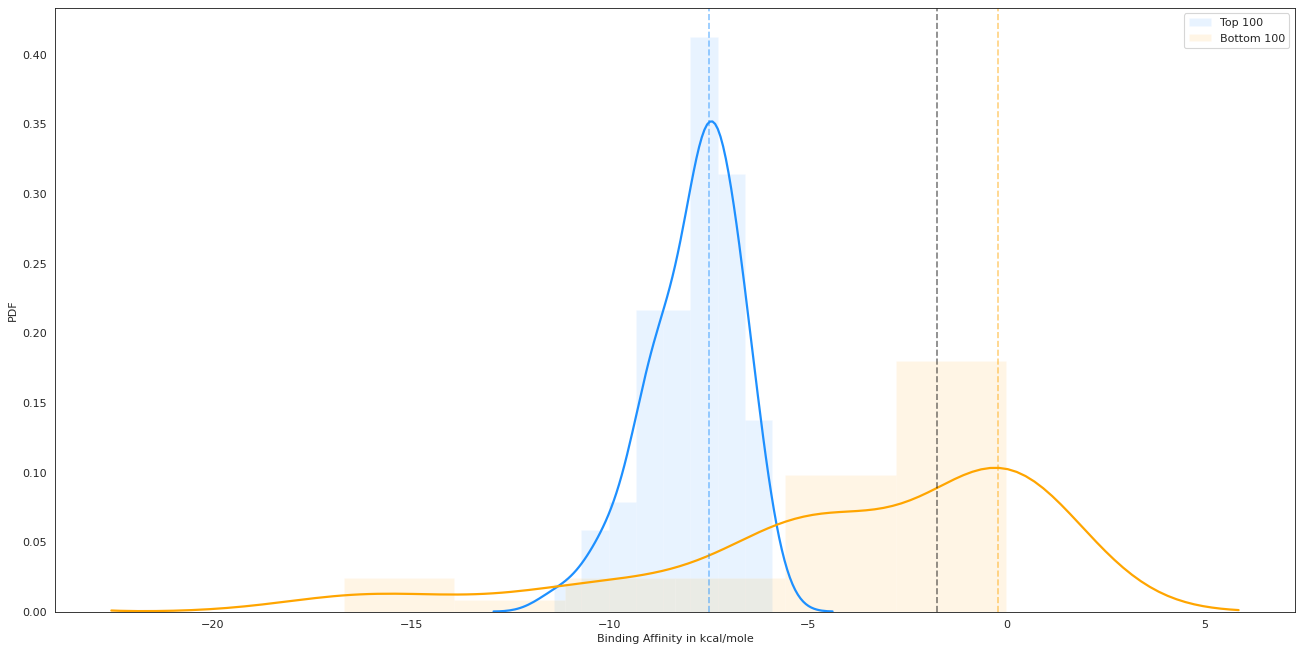

In [595]:
sns.set_style("white")

# Plot
kwargs = dict(hist_kws={'alpha':.1}, kde_kws={'linewidth':2})

plt.figure(figsize=(20,10), dpi= 80)
sns.distplot(top_predictions_auto_docked_f1['binding_affinity'].tolist(), color="dodgerblue", label="Top 100", **kwargs)
sns.distplot(bottom_predictions_auto_docked_f1['binding_affinity'].tolist(), color="orange", label="Bottom 100", **kwargs)
plt.xlabel('Binding Affinity in kcal/mole')
plt.ylabel('PDF')
plt.axvline(x=-1.75,color='k', linestyle='--',alpha=0.5)
plt.axvline(x=-7.5,color='dodgerblue', linestyle='--',alpha=0.5)
plt.axvline(x=-0.2,color='orange', linestyle='--',alpha=0.5)
#plt.xlim(50,75)
plt.legend();

## NDM Compounds

In [569]:
all_nodes = pd.read_csv('/data/sars-busters-consolidated/nw_files/WholeNetworkNodesTable.csv')

In [570]:
len(all_nodes[all_nodes['IsNDM'] == True]['Label'].tolist())

485

In [571]:
set(top_predictions_auto_docked_f1['InChiKey'].tolist()).intersection(set(all_nodes[all_nodes['IsNDM'] == True]['Label'].tolist()))

{'LXMSZDCAJNLERA-ZHYRCANASA-N',
 'MIJYXULNPSFWEK-GTOFXWBISA-N',
 'NYOXRYYXRWJDKP-GYKMGIIDSA-N',
 'YKOPWPOFWMYZJZ-PRIAQAIDSA-N'}

In [575]:
top_predictions_auto_docked_f1[top_predictions_auto_docked_f1['InChiKey'] == 'LXMSZDCAJNLERA-ZHYRCANASA-N'] # Spironolactone

,Unnamed: 0,InChiKey,target_aa_code,gene,Averaged Predictions,is_viral,binding_affinity,is_ligand_available,is_protein_available
33,524273,LXMSZDCAJNLERA-ZHYRCANASA-N,QEMHNFEEELTCPICYSIFEDPRVLPCSHTFCRNCLENILQASGNF...,TRIM59,0.398136,0,-7.1,NaN,NaN
73,524358,LXMSZDCAJNLERA-ZHYRCANASA-N,KLNVQKSQVYLYTNDRQMESQIMSKHPFIIATKRIKYLGIQLTRDM...,FAR2,0.389970,0,-10.2,NaN,NaN
81,524044,LXMSZDCAJNLERA-ZHYRCANASA-N,QSKTLSLKKKKKKKATFCLYNCQDFGLVCVWVVVVVLSGDTEPRFG...,ZC3H18,0.389237,0,-7.6,NaN,NaN


In [576]:
top_predictions_auto_docked_f1[top_predictions_auto_docked_f1['InChiKey'] == 'MIJYXULNPSFWEK-GTOFXWBISA-N'] # OLEANOLIC ACID

,Unnamed: 0,InChiKey,target_aa_code,gene,Averaged Predictions,is_viral,binding_affinity,is_ligand_available,is_protein_available
83,1273703,MIJYXULNPSFWEK-GTOFXWBISA-N,QEMHNFEEELTCPICYSIFEDPRVLPCSHTFCRNCLENILQASGNF...,TRIM59,0.389038,0,-8.0,NaN,NaN


In [577]:
top_predictions_auto_docked_f1[top_predictions_auto_docked_f1['InChiKey'] == 'NYOXRYYXRWJDKP-GYKMGIIDSA-N'] # Cholestenone

,Unnamed: 0,InChiKey,target_aa_code,gene,Averaged Predictions,is_viral,binding_affinity,is_ligand_available,is_protein_available
85,1225523,NYOXRYYXRWJDKP-GYKMGIIDSA-N,QEMHNFEEELTCPICYSIFEDPRVLPCSHTFCRNCLENILQASGNF...,TRIM59,0.388854,0,-7.1,NaN,NaN


In [578]:
top_predictions_auto_docked_f1[top_predictions_auto_docked_f1['InChiKey'] == 'YKOPWPOFWMYZJZ-PRIAQAIDSA-N'] # Echinocystic Acid

,Unnamed: 0,InChiKey,target_aa_code,gene,Averaged Predictions,is_viral,binding_affinity,is_ligand_available,is_protein_available
72,2675213,YKOPWPOFWMYZJZ-PRIAQAIDSA-N,QEMHNFEEELTCPICYSIFEDPRVLPCSHTFCRNCLENILQASGNF...,TRIM59,0.390092,0,-7.6,NaN,NaN


# Plot Rank Lists

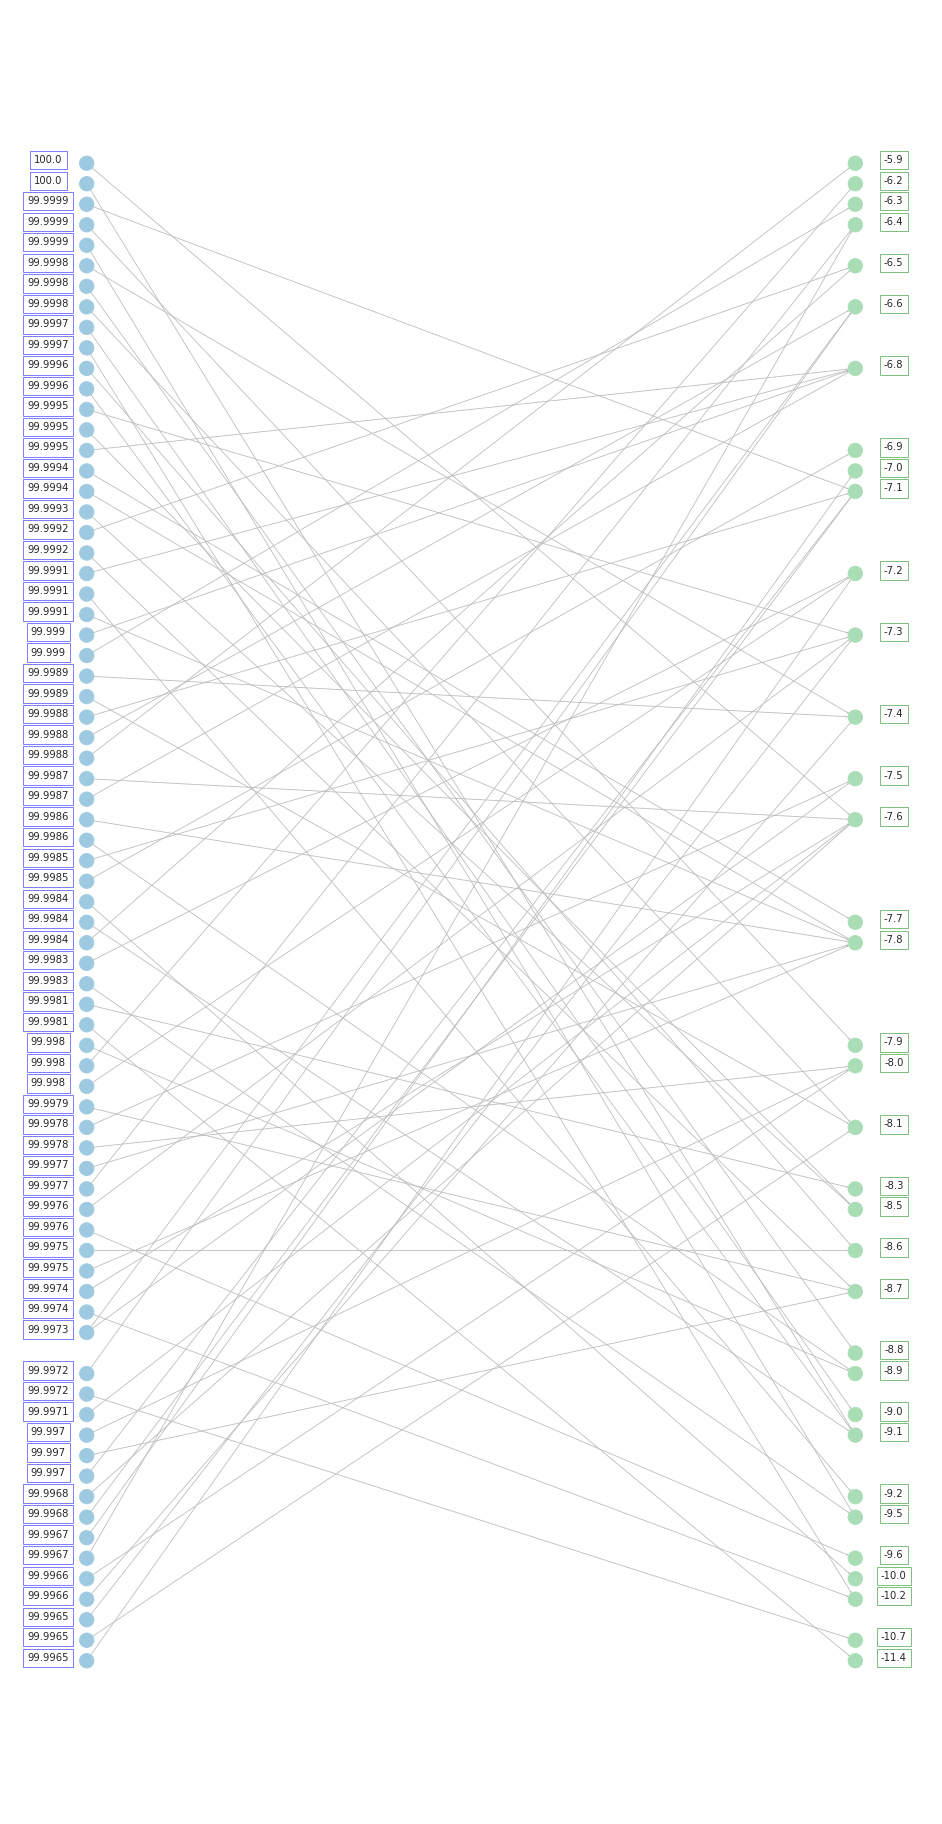

In [710]:
fig = plt.figure(1, figsize=(20, 40), dpi=60)

B = nx.DiGraph()
percentiles = top_predictions_ordered['Prediction_percentile'].tolist()
percentiles.sort(reverse = False)
binding_affinities = top_predictions_ordered['binding_affinity'].tolist()
binding_affinities.sort(reverse = False)
B.add_nodes_from(percentiles, bipartite=0) # Add the node attribute "bipartite"
B.add_nodes_from(binding_affinities, bipartite=1)
B.add_edges_from(list(zip(top_predictions_ordered['Prediction_percentile'].tolist(),top_predictions_ordered['binding_affinity'].tolist())))

# Separate by group
#l, r = nx.bipartite.sets(B)

color = nx.bipartite.color(B)

color_dict = {0:'#9ecae1',1:'#a8ddb5'}

color_list = [color_dict[i[1]] for i in B.nodes.data('bipartite')]

pos = {}

# Update position for node from each group

x_plot_list_1 = []
y_plot_list_1 = []

x_plot_list_2 = []
y_plot_list_2 = []

pos.update((node, (1, index)) for index, node in enumerate(percentiles))
for percentiles_val in percentiles:
    x,y = pos[percentiles_val]
    if (x not in x_plot_list_1) or (y not in y_plot_list_1):
        x_plot_list_1.append(x)
        y_plot_list_1.append(y)
        plt.text(x-0.05,y,s=str(round(percentiles_val,4)), fontsize=12, bbox=dict(edgecolor='blue', pad=5.0, facecolor='none', alpha=0.6),horizontalalignment='center')

pos.update((node, (2, index)) for index, node in enumerate(binding_affinities))
for ba_value in binding_affinities:
    x,y = pos[ba_value]
    if (x not in x_plot_list_2) or (y not in y_plot_list_2):
        x_plot_list_2.append(x)
        y_plot_list_2.append(y)
        plt.text(x+0.05,y,s=str(round(ba_value,4)), fontsize=12, bbox=dict(edgecolor='green', pad=5.0, facecolor='none', alpha=0.6),horizontalalignment='center')

nx.draw(B, pos=pos, font_weight='bold', edge_color='#bdbdbd', arrowsize=2,  arrows=True, node_color = color_list)
plt.show()